<a href="https://colab.research.google.com/github/angelmg10/BigDataVIU/blob/master/06MBIG_AG1_a_Introducci%C3%B3n_al_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Introducción al Clustering

Como problema de partida de ejemplo de como aplicar diferentes algoritmos de clustering vamos a utilizar unos datos del Producto Interior Bruto de los Estados de Estados Unidos en 2009. Los datos están en [Enlace](https://drive.google.com/open?id=1Rb_7eNacmktJM3RqETQmSLysXYjk5EDG)

# Preproceso Básico

Antes de empezar cualquier análisis hay que asegurar que las librerías básicas y de uso general (numpy, pandas, etc.) están correctamente importadas. 

También asegurarse de que dentro del entorno están las librerías actualizadas lo cual puede ser imprescindible en algunos momentos, como en este caso sucede con la librería de visualización *seaborn*

In [1]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.10.0)


In [0]:
import matplotlib.pyplot as plt
import numpy
import itertools
import seaborn as sns

## Carga de Datos

En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

In [4]:
# 0.1 load data from file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


Posteriormente utilizamos la librería [Pandas](https://pandas.pydata.org/) con el fin de poder manejar los datos en una estructura denominada DataFrame


In [0]:
# 0.2 load data in DataFrame
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col='city')




In [8]:
df.head()

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
city,,,,,,,,,,,,,,,,,,,,,,,
sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [0]:
df.shape

(51, 17)

df.drop('week_start_date')


In [0]:
df1=df.drop('week_start_date', axis=1)

Estos datos contienen para cada uno de los estados (*State*) las diferentes cantidades en producto interior bruto dentro de categorías que denominaríamos de nivel 2 de agregación, es decir, son una desagragción de niveles superiores. De esta forma encontramos datos como el PIB de Agricultura, Minería, Construcción, Comercio, etc. 

Una vez que contamos con el DataFrame de Pandas podríamos analizar qué características necesitamos y cuales deberíamos excluir. En este caso nos vamos a quedar con todas, aunque no todas sean significativas. 

In [22]:
df1.describe()
df1.fillna(method='ffill',inplace=True)
pd.isnull(df1).any()

year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_preci

## Transformaciones previas

Como consideración previa necesitamos transformar los datos a una misma escala, por ejemplo [0,1]. Esto es así porque diferentes items de nuestras características pueden tener ordenes de dimensión diferentes. Este proceso no siempre es necesario sobre todo si nos encontramos con variables que ya están en esa esa escala. 

En este caso vamos a optar por utilizar la operación [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), que pretende transformar a una escala con mínimo = 0 y máximo = 1. Esto puede generar cierta distorsión en los datos pero que puede ser conveniente para conseguir mejores resultados de clustering.  Otras opciones para reducir esta distorsión sería utilizar [MaxAbsScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler)

In [23]:
from sklearn import preprocessing 
min_max_scaler = preprocessing.MinMaxScaler()
datanorm = min_max_scaler.fit_transform(df1)
datanorm


array([[0.        , 0.32692308, 0.57822643, ..., 0.17419355, 0.48623853,
        0.02944966],
       [0.        , 0.34615385, 0.62994263, ..., 0.32258065, 0.68807339,
        0.01582919],
       [0.        , 0.36538462, 0.47944084, ..., 0.35483871, 0.74311927,
        0.07620099],
       ...,
       [1.        , 0.42307692, 0.71430355, ..., 0.35483871, 0.41284404,
        0.01362047],
       [1.        , 0.44230769, 0.80927023, ..., 0.29032258, 0.57798165,
        0.02944966],
       [1.        , 0.46153846, 0.77020581, ..., 0.4516129 , 0.68807339,
        0.03754832]])

# Análisis de Componentes Principales

El análisis de componentes principales (en español ACP, en inglés, PCA) es una técnica utilizada para reducir la dimensionalidad de un conjunto de datos. Intuitivamente la técnica sirve para hallar las causas de la variabilidad de un conjunto de datos y ordenarlas por importancia. Técnicamente, PCA busca la proyección según la cual los datos queden mejor representados en términos de mínimos cuadrados. PCA se emplea sobre todo en análisis exploratorio de datos y para construir modelos predictivos. 

PCA comporta el cálculo de la descomposición en autovalores de la matriz de covarianza, normalmente tras centrar los datos en la media de cada atributo.
Para ello utilizaremos el procedimiento [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) de scikitlearn

In [24]:
from sklearn import preprocessing 
scaler = preprocessing.StandardScaler()
states = scaler.fit_transform(df1)
states

array([[-2.04044804, -0.56635649, -0.06261869, ..., -1.55264768,
        -1.33870766, -0.48987568],
       [-2.04044804, -0.49975322,  0.27894877, ..., -0.37923554,
         0.06383973, -0.64616845],
       [-2.04044804, -0.43314995, -0.71506308, ..., -0.12414594,
         0.44635265,  0.04658872],
       ...,
       [ 1.65883268, -0.23334015,  0.83612328, ..., -0.12414594,
        -1.8487249 , -0.67151323],
       [ 1.65883268, -0.16673689,  1.46334512, ..., -0.63432513,
        -0.70118612, -0.48987568],
       [ 1.65883268, -0.10013362,  1.20533821, ...,  0.64112285,
         0.06383973, -0.39694484]])

Una de las ventajas del PCA para reducir la dimensionalidad de un grupo de datos, es que retiene aquellas características del conjunto de datos que contribuyen más a su varianza, manteniendo un orden de bajo nivel de los componentes principales e ignorando los de alto nivel. 

El objetivo es que esos componentes de bajo orden a veces contienen el aspecto “más importante” de esa información 

En este caso y como nuestro propósito principal es la visualización utilizaremos únicamente **dos componentes principales**

In [25]:
#2. PCA Estimation
from sklearn.decomposition import PCA
estimator = PCA (n_components = 3)
X_pca = estimator.fit_transform(states)
X_pca


array([[-3.09498882,  3.24809287, -0.03567552],
       [-2.29820963,  1.04616416, -0.27538227],
       [-1.8773604 , -0.40228925,  0.41593307],
       ...,
       [ 1.66413316,  2.84789919,  1.63547878],
       [ 2.80930101,  2.8359296 ,  1.2492391 ],
       [ 3.69919817,  0.63430942, -0.70888543]])

A continuación, se muestra el porcentaje de varianza explicado por cada uno de los componentes seleccionados.

En PCA cada componente principal tiene una cierta desviación, que en conjunto suman hasta el 100% de la desviación total.

Para cada componente principal, un cociente de su varianza con respecto a la varianza total se denomina "proporción de varianza explicada".

In [26]:
print(estimator.explained_variance_ratio_) 

[0.33070815 0.24963251 0.12402419]


In [28]:
pd.DataFrame(numpy.matrix.transpose(estimator.components_), columns=['PC-1', 'PC-2', 'PC-3'], index=df1.columns)

,PC-1,PC-2,PC-3
year,0.175831,0.037470,0.036475
weekofyear,0.059402,-0.194973,-0.132977
ndvi_ne,0.286336,0.112888,-0.075741
ndvi_nw,0.281581,0.106497,-0.080420
ndvi_se,0.217898,0.096569,-0.162827
ndvi_sw,0.251905,0.106397,-0.140610
precipitation_amt_mm,0.183932,-0.128717,0.374670
reanalysis_air_temp_k,-0.071105,-0.358472,-0.249023
reanalysis_avg_temp_k,0.072656,-0.334727,-0.290847
reanalysis_dew_point_temp_k,0.135725,-0.363572,0.113205


Finalmente, PCA encuentra un nuevo sistema de coordenadas en el que cada punto tiene un nuevo valor (x,y). Los ejes no significan realmente nada físico; se eligen para dar a uno de ellos la mejor de las variaciones.

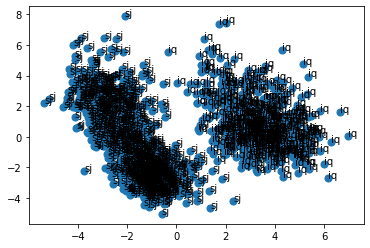

In [29]:
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1] ,s=50)

# anotación 
#numbers = numpy.arange(len(X_pca)) # etiquetas numéricas
for i in range(0,len(X_pca)):
    ax.annotate(df.iloc[i,:].name[0:2], (X_pca[i,0], X_pca[i,1]))

# Clustering Jerárquico


Los algoritmos de clustering jerárquico se distinguen por generar como resultado una estructura de
grupos organizada en forma de árbol jerárquico. Este árbol, denominado dendrograma es un fiel reflejo de como los clusters se relacionan unos con otros. Dentro de la estructura, el nodo superior o “raíz” del árbol engloba la totalidad de los elementos de la colección, mientras que
los nodos “hoja” representan a los grupos de elementos con similitud máxima. Cada nivel intermedio
puede ser visto como la combinación de dos agrupaciones del nivel más bajo, o bien, como una parte
de la división de la agrupación de nivel más alto.



A continuación, ejecutemos un algoritmo de clustering jerárquico con el fin de observar como se pueden están organizados los elementos que están bajo estudio, en este caso los estados de Estados Unidos. 

En primer lugar vamos a calcular la matriz de similitud entre los diferentes elementos utilizando para ello la [distancia euclídea](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) y la visualizamos utilizando la librería seaborn y el [gráfico de calor](https://seaborn.pydata.org/generated/seaborn.heatmap.html)



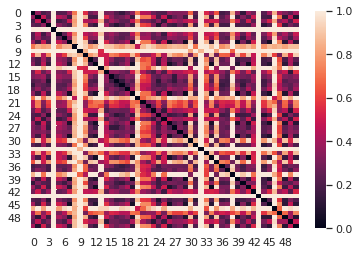

In [0]:
#3. Hierarchical Clustering
# 3.1. Compute the similarity matrix
import sklearn.neighbors
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(datanorm)

# 3.1.1 Visualization
import seaborn as sns; sns.set()
ax = sns.heatmap(matsim,vmin=0, vmax=1)



Una vez calculada la matriz de similitud pasamos a construir el dendrograma. Para ello hay que decidir que tipo de [distancia intercluster](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) utilizamos, lo cual dependerá del problema que tengamos que afrontar. En un extremo estará el enlace simple que permitirá manejar fácilmente elementos especiales (*outliers*) y clusters de muy diversa forma, pero que nos ofrecerá grupos poco balanceados. En el otro extremo el enlace completo nos ofrecerá agrupaciones más equlibradas pero que supondrán la división de grupos mayoritarios. De forma intermedia tendremos otros índices como Ward o Average 
para ver cómo se distribuyen los datos.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


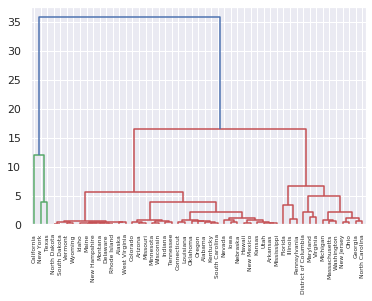

<Figure size 432x288 with 0 Axes>

In [0]:
# 3.2. Building the Dendrogram	
from scipy import cluster
clusters = cluster.hierarchy.linkage(matsim, method = 'ward')
# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
cluster.hierarchy.dendrogram(clusters, labels = df.index)

# 3.2.1 Visualization
f = plt.figure()
plt.show()
#f.savefig( "test.png")
#files.download('test.png')


Aunque aquí el corte más que lineal tendría que hacerse ad-hoc, es decir, a partir de un corte con más granularidad (más grupos) deberíamos entonces reagrupar clusters que sean muy similares entre sí.

De todos modos vamos a cortar a un nivel lógico a pesar de darnos algunos valores atípicos (grupos de un solo elemento)

Por ejemplo, un corte a nivel 5 con un enlace completo da lugar a 5 grupos, alguno de ellos con muy pocos elementos 



In [0]:
cut = 10 # !!!! ad-hoc
labels = cluster.hierarchy.fcluster(clusters, cut , criterion = 'distance')

labels

array([3, 3, 3, 3, 2, 3, 3, 3, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 1,
       3, 3, 4, 4, 3, 3, 3], dtype=int32)

Una vez terminado el clustering podemos aplicar ciertas métricas de calidad del mismo como el [coeficiente Silohuette] (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)



In [0]:
# tratamos el cluster -1 como cluster de outliers
from sklearn import metrics
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(datanorm, labels))

Estimated number of clusters: 4
Silhouette Coefficient: 0.492


Y podríamos comenzar con la caracterízación de los grupos, en primer lugar visualizandolos utilizando la proyección PCA

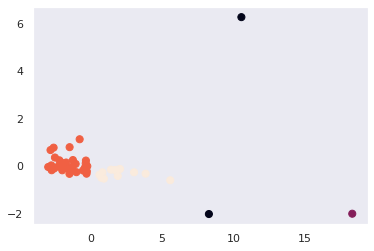

In [0]:
#plotting orginal points with color related to label
fig, ax = plt.subplots()
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels,s=50)
#for i in range(0,len(X_pca)):
#    ax.annotate(df.iloc[i,:].name[0:3], (X_pca[i,0], X_pca[i,1]))
plt.grid()
plt.show()

Y luego obteniendo estadísticos básicos que nos permitan interpretar que significa cada grupo

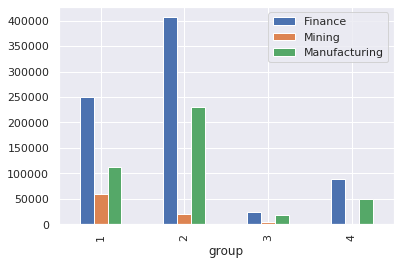

In [0]:
df['group'] = labels


res = df[['Finance', 'Mining', 'Manufacturing', 'group']].groupby(('group')).mean()
res.plot(kind='bar', legend=True)




Y podemos utilizar filtros para saber que estados pertenecen a cada grupo

In [0]:
df[df['group'] == 3]

,Agriculture,Mining,Utilities,Construction,Manufacturing,Wholesale trade,Retail,Transportation,Information,Finance,Buss. Services,Education,Arts,Oth Serv.,Fed. civ,Fed. military,State.1,group
State,,,,,,,,,,,,,,,,,,
Alabama,2040,2982,4965,7866,25444,9712,12287,4471,4244,25185,16090,12957,4826,4694,7174,4367,19746,3
Alaska,305,14327,612,2143,1867,1026,1943,4510,948,5416,2884,2757,1273,737,1882,2398,4929,3
Arizona,1528,4687,5677,13167,20026,14283,18439,6859,6559,51282,27353,22549,10487,5231,6247,3833,25123,3
Arkansas,2537,2249,2467,4266,14010,7257,7070,4120,10864,14879,8641,8432,2797,2283,2326,1148,10494,3
Colorado,2112,11330,3152,11612,19429,13309,14140,6386,20171,45343,34342,17061,10598,5944,6900,4766,21580,3
Connecticut,314,113,3998,6989,27665,12795,11314,4123,12134,69118,25348,21758,5781,4473,2488,2928,18668,3
Delaware,276,1,868,1750,4732,2258,2423,752,1210,23162,5992,4075,1488,868,659,632,4945,3
Hawaii,441,108,1428,4088,1302,2044,4377,2542,1467,14840,5694,5006,5251,1561,3489,5232,6215,3
Idaho,2494,809,867,2729,6326,2962,4179,1494,1161,9854,5690,4422,1684,1149,1495,663,6086,3


O sacar todos los estadísticos basicos para luego pasarlo a otra herramienta (Excel)

In [0]:
res = df[['Agriculture', 'Utilities', 'group']].groupby('group').describe()
res

Agriculture                             ... Utilities                  
            count          mean          std  ...       50%      75%      max
group                                         ...                            
1             2.0   3980.000000  2805.799708  ...   21265.0  22881.0  24497.0
2             1.0  25439.000000          NaN  ...   27999.0  27999.0  27999.0
3            35.0   1919.600000  1706.742877  ...    2302.0   3579.5   5677.0
4            13.0   2856.384615  1965.264509  ...    7951.0   9497.0  16011.0

[4 rows x 16 columns]

In [0]:
res.to_excel('res.xlsx')
files.download('res.xlsx')

Para finalizar buscamos una visualización un poco especial con [seaborn.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html)

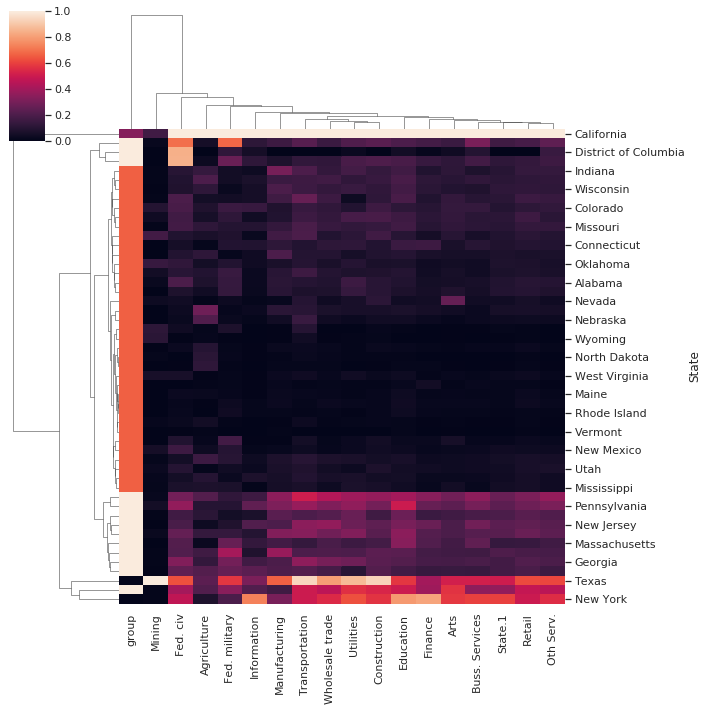

In [0]:
sns.set(color_codes=True)
sns.clustermap(df, standard_scale=1)

# K-means

The k-means algorithm is based on the idea that a central point (centroid) can represent a cluster. Normally this point is the mean or median of a group of points (may not be an element of the whole to be analyzed). The k-means algorithm establishes a distance between the elements by selecting a predefined number of centroids.

K-means uses these pre-selected centroids as "seeds" in the process of building the clusters. To do this, a cluster is assigned to each centroid, in an iterative process. The cluster assigned to each centroid is the closest to it, and the distance is measured between the element to be included and the mean value for all the clusters. As mentioned above, the goal of the k- means algorithm process is to minimize an error function or distance, for example, the sum of squared errors.



### Parametrization



En primer lugar vamos a establecer los parámetros que vamos a considerar por defecto

In [0]:
# parameters
init = 'random' # initialization method 

# to run 10 times with different random centroids 
# to choose the final model as the one with the lowest SSE
iterations = 10

# maximum number of iterations for each single run
max_iter = 300 

# controls the tolerance with regard to the changes in the 
# within-cluster sum-squared-error to declare convergence

tol = 1e-04 

 # random seed
random_state = 0

Vamos a elegir K dependiendo de los valores que tome el clustering en cuanto a Distorsión (SSE) y Silhouette desde k = 2 a k = 11

*En este caso además vamos a optar por hacer el clustering sobre los datos proyectados mediante PCA*

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
silhouettes = []

for i in range(2, 11):
    km = KMeans(i, init, n_init = iterations ,max_iter= max_iter, tol = tol,random_state = random_state)
    labels = km.fit_predict(X_pca)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(X_pca, labels))

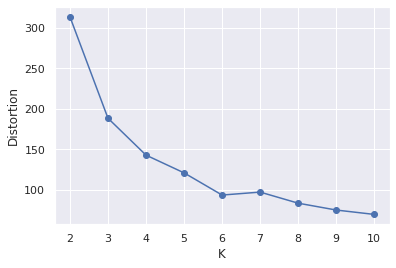

In [0]:
plt.plot(range(2,11), distortions, marker='o')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

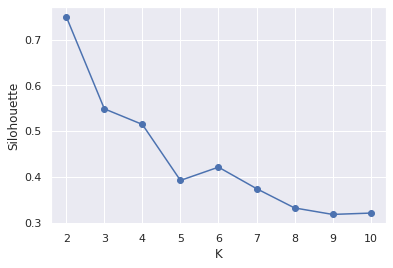

In [0]:
plt.plot(range(2,11), silhouettes , marker='o')
plt.xlabel('K')
plt.ylabel('Silohouette')
plt.show()

### Ejecución del Algoritmo

Vamos a seleccionar k = 4 con el fin de ejecutar el clustering

In [0]:
k = 4

km = KMeans(k, init, n_init = iterations ,
            max_iter= max_iter, tol = tol, random_state = random_state)

y_km = km.fit_predict(X_pca)

Vamos a calcular los valores finales de las métricas del algoritmo

In [0]:
from sklearn import metrics
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(datanorm, y_km))
      
print('Distortion: %.2f' % km.inertia_)

Silhouette Coefficient: 0.462
Distortion: 142.94


Y vamos a visualizar los resultados


In [0]:
km.labels_

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 1,
       0, 0, 3, 3, 0, 0, 0], dtype=int32)

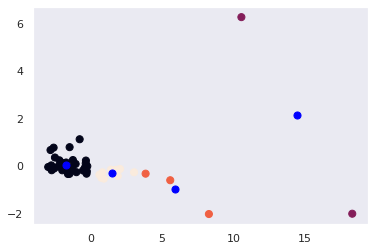

In [0]:
#plotting orginal points with color related to label
plt.scatter(X_pca[:,0], X_pca[:,1], c=km.labels_,s=50)
# plotting centroids
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='blue',s=50)
# 
plt.grid()
plt.show()
      

Y a proceder a su interpretación

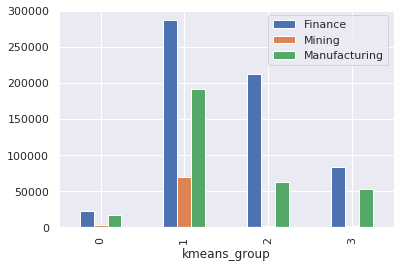

In [0]:
df['kmeans_group'] = km.labels_


res = df[['Finance', 'Mining', 'Manufacturing', 'kmeans_group']].groupby(('kmeans_group')).mean()
res.plot(kind='bar', legend=True)

# DBSCAN



La idea clave de los algoritmos de clustering basados en densidad es que asumen que los grupos
están definidos en áreas de gran densidad de datos. Las zonas pocos densas separan los grupos.
DBSCAN es el primer algoritmo que se definió basado en la densidad describiéndose los conceptos
de punto central, borde y ruido. Los puntos centrales poseen un área de vecindad para
un determinado radio que tiene por lo menos un número mínimo de puntos, o sea que su área de
vecindad excede un determinado umbral

### Parametrización


Dibujamos en un gráfico la distancia mas corta al vecino para obtener el epsilon a utilizar en DBSCAN.
Como MintPts ponemos un número bajo, considerando que tener 3 estados parecidos es ya sinónimo de un área densa. 

NOTA: Para realizar estos cálculos nos vamos a apoyar en la matriz de similitud calculada para la ejecución del Algoritmo Jerárquico


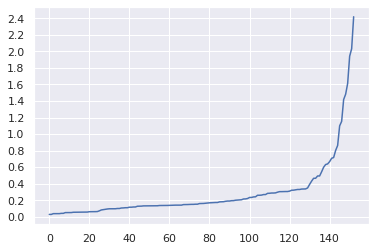

In [0]:
minPts=3
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(datanorm, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(datanorm):
    for j in range(len(datanorm)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
            
seq.sort()
# establecer intervalo ejes
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(numpy.arange(0, 150, 20))
ax.set_yticks(numpy.arange(0, 3, 0.2))

plt.plot(seq)


plt.show()

Aunque se podría probar con otras opciones vamos a optar por probar  a realizar diferntes clusters desde 0.2 a 0.7 con intervalos de 0.1. De todas formas la disposición de los datos hará que DBSCAN únicamente aisle una zona densa de aquellos elementos que considera *outliers*

## Ejecución

In [0]:
from sklearn.cluster import DBSCAN

for eps in numpy.arange(0.20, 0.7, 0.10):
  db = DBSCAN(eps, min_samples=minPts).fit(datanorm)
  core_samples_mask = numpy.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  print (eps, n_clusters_)
  
#labels

0.2 1
0.30000000000000004 1
0.4000000000000001 1
0.5000000000000001 2
0.6000000000000001 1


In [0]:
db = DBSCAN(eps=0.5, min_samples=minPts).fit(datanorm)
labels = db.labels_
labels

array([ 0,  0,  0,  0, -1,  0,  0,  0,  1, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0])

Visualizamos los resultados

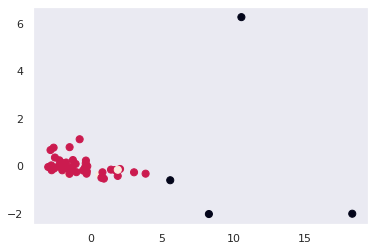

In [0]:
#plotting orginal points with color related to label
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels,s=50)
plt.grid()
plt.show()

Y aunque podríamos proceder a su intepretación en este caso lo que vamos a hacer es identificar aquellos elementos que son outliers

In [0]:
df['dbscan_group'] = labels

df[df['dbscan_group'] == -1]

,Agriculture,Mining,Utilities,Construction,Manufacturing,Wholesale trade,Retail,Transportation,Information,Finance,Buss. Services,Education,Arts,Oth Serv.,Fed. civ,Fed. military,State.1,dbscan_group
State,,,,,,,,,,,,,,,,,,
California,25439,20279,27999,65707,229479,100603,109363,41864,134655,406685,236025,133118,71649,42069,34009,29132,198300,-1
Florida,5458,1278,16011,35659,38284,47080,53163,21177,29121,161861,85390,67777,41358,19643,14272,10225,73926,-1
New York,1996,1035,18033,38050,70415,55710,55085,21153,99235,333404,143021,105701,42176,23629,16271,5966,120780,-1
Texas,5964,119695,24497,61603,153204,80764,68416,39577,41877,167303,122764,77579,37452,26077,21783,17007,101670,-1


#  Expectation - Maximization

En el clustering probabilístico se parte de un conjunto de un conjunto de observaciones o muestras
las cuales son independientes e idénticamente distribuidas aleatoriamente. En este tipo de algoritmos
se asume que la probabilidad de que dado un cluster 𝑆𝑖 el conjunto de muestras 𝑌 pertenezca a ella,
tiene una forma paramétrica conocida, determinada por un conjunto de parámetros θ𝑖. Este conjunto
de parámetros dependerá de la distribución elegida. El objetivo en cuestión es buscar aquellas
distribuciones que mejor generan el conjunto de datos, y para ello se utiliza la información obtenida
por las muestras observadas para estimar de forma óptima los parámetros θ𝑖 de cada distribución
generadora.

En este caso vamos a optar por utilizar una combinación de Gaussianas bajo el Gaussian Mixture Model.

Con el fin de determinar el número de clusters (*k*) vamos a utilizar en este caso el [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) Bayesian Information Criterion. Este criterio compara el ajuste de diferentes modelos pero penalizando la complejidad del modelo (número de parámetros). El modelo con el menor valor de BIC es el que debe ser elegido

In [0]:
from sklearn.mixture import GaussianMixture

lowest_bic = numpy.infty
bic = []
best_cv = 'full'
best_k = 3
cv_types = ['spherical', 'tied', 'diag', 'full']
n_components_range = range(1, 7)
for cv_type in cv_types:
    for k in range(1, 7):
        gmm = GaussianMixture(n_components=k, covariance_type=cv_type, init_params='random')
        gmm.fit(X_pca)
        bic.append(gmm.bic(X_pca))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_cv = cv_type
            best_k = k
            
print ("Mejor valor K", best_k, "Mejor tipo de Covarianza", best_cv)

Mejor valor K 5 Mejor tipo de Covarianza full


Además de Calcular el mejor valor de K vamos además a graficar los resultados para obtener más información sobre el análisis realizado de acuerdo a lo recomendado en [enlace](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html)

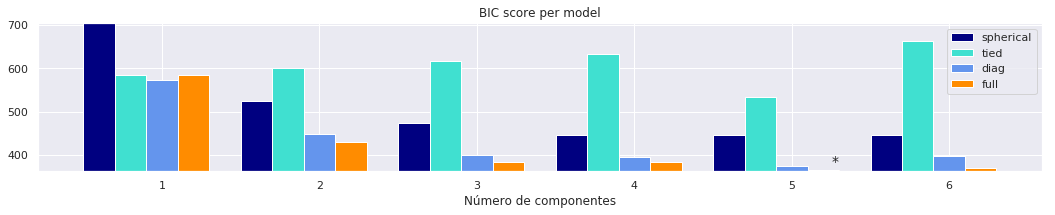

In [0]:
# Plot the BIC scores
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []
plt.figure(figsize=(18, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = numpy.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([min(bic) * 1.01 - .01 * max(bic), max(bic)])
plt.title('BIC score per model')
xpos = numpy.mod(numpy.argmin(bic), len(n_components_range)) + .65 +\
    .2 * numpy.floor(numpy.argmin(bic) / len(n_components_range))
plt.text(xpos, min(bic) * 0.97 + .03 * max(bic), '*', fontsize=14)
spl.set_xlabel('Número de componentes')
spl.legend([b[0] for b in bars], cv_types)

Ejecutaremos el algoritmo con los mejores parámetros obtenidos

In [0]:
EM = GaussianMixture(n_components=best_k, covariance_type=best_cv, init_params='random')
EM.fit(X_pca)
labels =  EM.predict(X_pca)
n_clusters = best_k - (1 if -1 in labels else 0)

Una vez ejecutado el módelo óptimo del algoritmo visualizamos los resultados utilizando la representación PCA

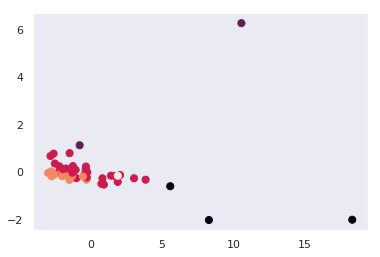

In [0]:
#plotting orginal points with color related to label
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels,s=50)
plt.grid()
plt.show()

Y procedemos a la interpretación de los resultados

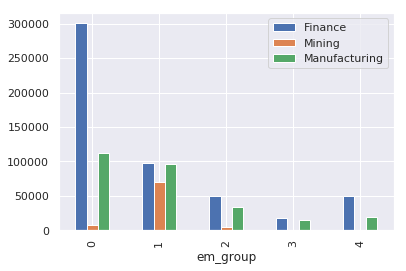

In [0]:
df['em_group'] = labels


res = df[['Finance', 'Mining', 'Manufacturing', 'em_group']].groupby(('em_group')).mean()
res.plot(kind='bar', legend=True)